In [59]:
import scipy.io
import os
import h5py
import numpy as np
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt
# from scipy.stats import sem
from scipy.stats import wilcoxon
import pandas as pd
import json
import jdata as jd
import re
import pickle

from nbconvert.preprocessors import ExecutePreprocessor
from nbconvert import NotebookExporter
import nbformat
from tqdm import tqdm  # Importer tqdm pour la barre de progression

import shutil

In [8]:
# qt for popup window (savable as pdf, svg...), inline for inline plot, notebook for interactive plot, widget for interactive plot
%matplotlib widget 
plt.ioff()

# Functions

In [9]:
# import tkinter as tk
# from tkinter import filedialog

# def open_select_folders_dialog():
#     class SelectFoldersDialog:
#         def __init__(self, master):
#             self.master = master
#             self.selected_folders = []

#             self.label = tk.Label(master, text="Sélectionnez les dossiers :")
#             self.label.pack()

#             self.add_button = tk.Button(master, text="Ajouter un dossier", command=self.add_folder)
#             self.add_button.pack()

#             self.confirm_button = tk.Button(master, text="Confirmer la sélection", command=self.confirm_selection)
#             self.confirm_button.pack()

#         def add_folder(self):
#             folder = filedialog.askdirectory()
#             if folder:
#                 self.selected_folders.append(folder)
#                 print("Dossier ajouté :", folder)

#         def confirm_selection(self):
#             if self.selected_folders:
#                 print("Sélection confirmée :", self.selected_folders)
#                 self.master.destroy()
#             else:
#                 print("Aucun dossier sélectionné. Veuillez ajouter au moins un dossier.")

#                 # Si aucun dossier n'est sélectionné, vous pouvez choisir de quitter l'application ici
#                 # self.master.destroy()

#     def open_select_folders_dialog():
#         root = tk.Tk()
#         dialog = SelectFoldersDialog(root)
#         root.mainloop()

#         return dialog.selected_folders  # Retourner les dossiers sélectionnés

#     return np.unique(open_select_folders_dialog())

In [30]:
import tkinter as tk
from tkinter import filedialog

def browse(type,extra,multiple=False):
    if type == 'file':
        if multiple:
            browsed = filedialog.askopenfilenames(title='Select your files '+extra)
        else:
            browsed = filedialog.askopenfilename(title='Select a file '+extra)
    elif type == 'folder':
        if multiple:
            dirselect = filedialog.Directory(title='Select your folders '+extra)
            browsed = []
            while True:
                d = dirselect.show()
                if not d: break
                browsed.append(d)
        else:
            browsed = filedialog.askdirectory(title='Select a folder '+extra)
    
    return browsed

In [42]:
def maestro_function(selected_folders, analyse_path, analysis_script):
    # Nombre total de dossiers à analyser
    total_folders = len(selected_folders)

    # tqdm pour afficher une barre de progression
    for i, selected_path in enumerate(tqdm(selected_folders, desc="Analyzing folders", unit="folder")):

        exp_id = "_".join([element for element in split_path(selected_path) if 'animal' in element][0].split('_')[0:2])

        executed_notebook = analysis_script
        result_notebook = os.path.join(analyse_path, f"Analysis_{exp_id}.ipynb")  

        jd.save(selected_path, os.path.join(analyse_path, 'path.json'))

        # Charger le notebook à exécuter
        with open(executed_notebook, 'r', encoding='utf-8') as f:
            notebook = nbformat.read(f, as_version=4)

        # Créer un préprocesseur pour exécuter le notebook
        preprocessor = ExecutePreprocessor(timeout=None)

        # Exécuter le notebook
        preprocessor.preprocess(notebook)

        # Exporter le notebook exécuté
        exporter = NotebookExporter()
        body, resources = exporter.from_notebook_node(notebook)

        # Écrire le notebook exécuté dans un fichier
        with open(result_notebook, 'w', encoding='utf-8') as f:
            f.write(body)

        os.makedirs(os.path.join(analyse_path, 'Path'), exist_ok=True)
        shutil.move(os.path.join(analyse_path, 'path.json'), os.path.join(analyse_path, 'Path', f"{exp_id}.json"))

In [12]:
def vMI_function(AllData, save = False,s=35,alpha=0.6):
    for pos_title, posOrientation in zip(['Mediolateral', 'Anteroposterior'], ['ML_pos', 'AP_pos']):
        for condition in ['first', 'second']:
            for direction in ['CW','CCW']:
                for animal in AllData:
                    pos = AllData[animal]['informative_data'][posOrientation]
                    Nclust = AllData[animal]['SUA_data']['Nclust']
                    AllDepth = AllData[animal]['MUA_data']['AllDepth']
                    vMI = AllData[animal]['Statistics_data']['vMI']

                    plt.scatter(pos*np.ones(Nclust), AllDepth, c=vMI[condition][direction], cmap='coolwarm', s=s, alpha=alpha)

                plt.gca().invert_yaxis()
                if posOrientation == 'ML_pos':
                    plt.gca().invert_xaxis()

                plt.colorbar(label=f"{direction} modulation index")

                plt.xlabel(f"{pos_title} position (mm)")
                plt.ylabel("Depth (µm)")
                plt.title(f"{direction} modulation of units, {condition} condition")

                if save:
                    direction_modulation_folder = os.path.join(analyse_path, 'Direction_modulation')
                    os.makedirs(direction_modulation_folder, exist_ok=True)
                    plt.savefig(os.path.join(direction_modulation_folder , f"{direction}_modulation_{condition}_{pos_title}.png"))
                    plt.close()
                else:
                    plt.show()

In [78]:
import random

def dirMI_function(AllData, save = False,s=35,alpha=0.6):
    for pos_title, posOrientation in zip(['Mediolateral', 'Anteroposterior'], ['ML_pos', 'AP_pos']):
        for condition in ['first', 'second']:
            for animal in AllData:
                pos = AllData[animal]['informative_data'][posOrientation]
                Nclust = AllData[animal]['SUA_data']['Nclust']
                AllDepth = AllData[animal]['MUA_data']['AllDepth']
                dirMI = AllData[animal]['Statistics_data']['dirMI']

                plt.scatter((pos+random.uniform(-0.5,0.5))*np.ones(Nclust), AllDepth, c=dirMI[condition], cmap='coolwarm', s=s, alpha=alpha)

            plt.gca().invert_yaxis()
            if posOrientation == 'ML_pos':
                plt.gca().invert_xaxis()

            plt.colorbar(label=f"Direction Modulation Index\n(CW - CCW) / (CW + CCW)")

            plt.xlabel(f"{pos_title} position (mm)")
            plt.ylabel("Depth (µm)")
            plt.title(f"CW vs CCW preference")

            if save:
                direction_preference_folder = os.path.join(analyse_path, 'Direction_preference')
                os.makedirs(direction_preference_folder, exist_ok=True)
                plt.savefig(os.path.join(direction_preference_folder , f"Direction_preference_{condition}_{pos_title}.png"))
                plt.close()
            else:
                plt.show()

In [14]:
def split_path(path):
    drive, path_without_drive = os.path.splitdrive(path)
    path_segments = []
    while True:
        head, tail = os.path.split(path_without_drive)
        if tail:
            path_segments.insert(0, tail)
            path_without_drive = head
        else:
            if head:
                path_segments.insert(0, head)
            break
    path_segments.insert(0, drive)
    return path_segments

In [15]:
# def select_files():
#     root = tk.Tk()
#     root.withdraw()  # Hide the main window

#     files = filedialog.askopenfilenames(
#         title="Sélectionner des fichiers",
#         filetypes=[("Tous les fichiers", "*.*")]  # Types de fichiers autorisés
#     )

#     root.destroy()  # Destroy the root window

#     return files

In [73]:
def load(all):
    AllData = {}

    data_folder = os.path.join(analyse_path, 'Data')
    


    if all:
        files_to_load = sorted(os.listdir(data_folder))
        
        for i, file in enumerate(tqdm(files_to_load, desc="Data loading", unit="folder")):
            # AllData[file.split('_')[1]] = jd.load(os.path.join(data_folder, file))
            with open(os.path.join(data_folder, file), 'rb') as FILE_READER:
                AllData[file.split('_')[1]] = pickle.load(FILE_READER)
    else:
        files_to_load = browse('file',multiple=True, extra='to load')

        for i, file in enumerate(tqdm(files_to_load, desc="Data loading", unit="folder")):
            # AllData[file.split('_')[1]] = jd.load(file)
            with open(file, 'rb') as FILE_READER:
                AllData[file.split('_')[1]] = pickle.load(FILE_READER)

    return AllData

# Initiation

In [31]:
analysis_script = browse('file', extra = 'for analysis') # 'Analysis_dark_vestibular.ipynb'
selected_folders = browse('folder', multiple=True, extra = 'to analyze')
analyse_path = browse('folder', extra = 'to save resulting data') # r'C:\Users\ayazici\Documents\Analyses\Vestibular_experiments'

print('Analysis script:', analysis_script)
print('Selected folders:', selected_folders)
print('Analysis path:', analyse_path)

Analysis script: C:/Users/gbouvier/BOUVIER/Analysis_dark_vestibular.ipynb
Selected folders: ['P:/SharedFiles/Abdussamed/Pulvinar_rec_dark_80degs/animal21_a53d1s1_ephys/21a53d1s1_210604_150840', 'P:/SharedFiles/Abdussamed/Pulvinar_rec_dark_80degs/animal21_a51d1s1_ephys/21a51d1s1_210602_110516', 'P:/SharedFiles/Abdussamed/Pulvinar_rec_dark_80degs/animal21_a21d1s1_ephys/21a21d1s1_210408_155731', 'P:/SharedFiles/Abdussamed/Pulvinar_rec_dark_80degs/animal21_a19d1s1_ephys/21a19d1s1_210403_130057', 'P:/SharedFiles/Abdussamed/Pulvinar_rec_dark_80degs/animal21_a18d1s1_ephys/21a18d1s1_210401_111241', 'P:/SharedFiles/Abdussamed/Pulvinar_rec_dark_80degs/animal21_a17d1s1_ephys/21a17d1s1_210330_130118', 'P:/SharedFiles/Abdussamed/Pulvinar_rec_dark_80degs/animal21_a17d1s1_ephys/21a17d1s1_210330_130118', 'P:/SharedFiles/Abdussamed/Pulvinar_rec_dark_80degs/animal21_a15d1s1_ephys/21a15d1s1_210326_163524']
Analysis path: C:/Users/ayazici/Documents/Analyses/Vestibular_experiments


# Analysis

In [64]:
maestro_function(selected_folders, analyse_path, analysis_script)

Analyzing folders: 100%|██████████| 8/8 [08:16<00:00, 62.03s/folder]


In [74]:
AllData = load(all=True)

Data loading: 100%|██████████| 7/7 [00:25<00:00,  3.69s/folder]


In [76]:
vMI_function(AllData, save=True, s=45, alpha=0.4)

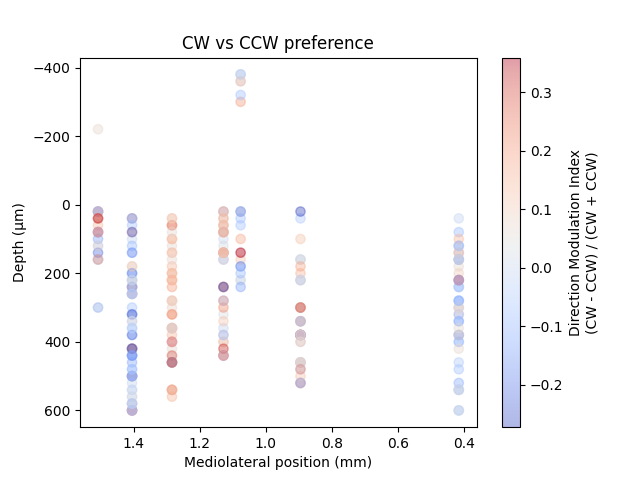

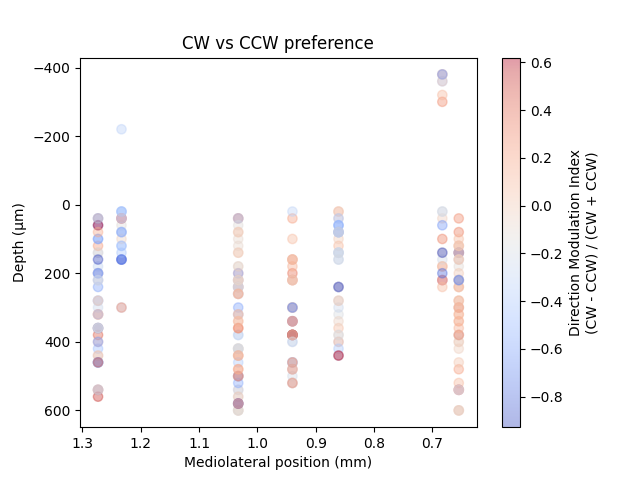

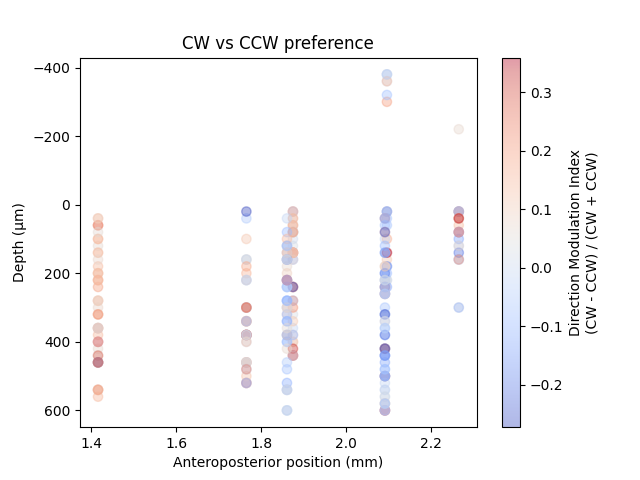

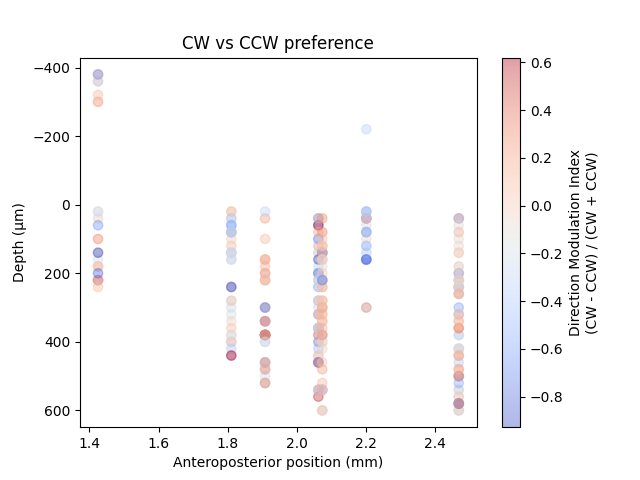

In [79]:
dirMI_function(AllData, save=False, s=45, alpha=0.4)

# Figures to show

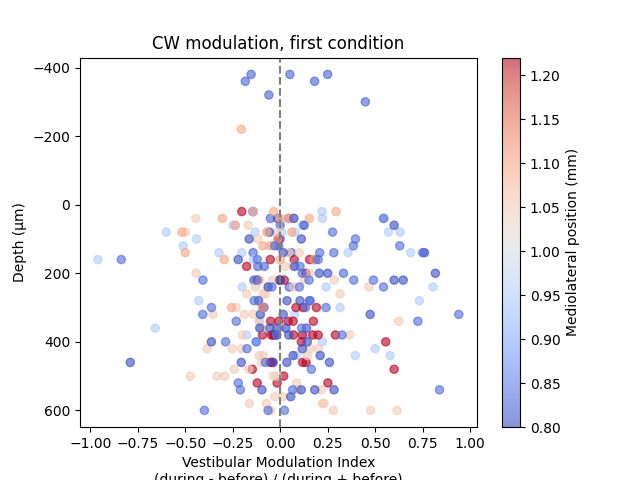

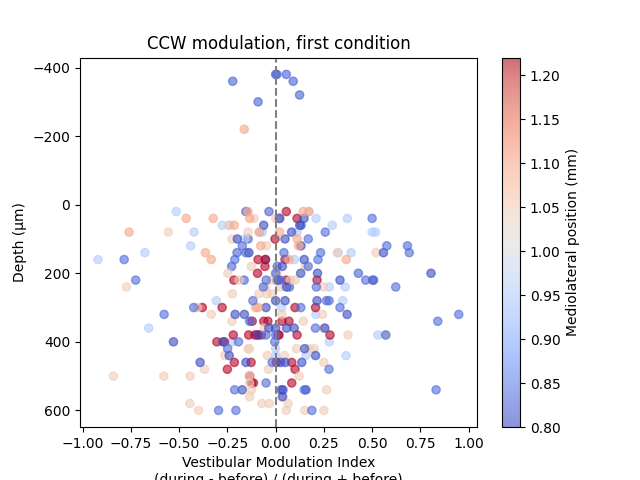

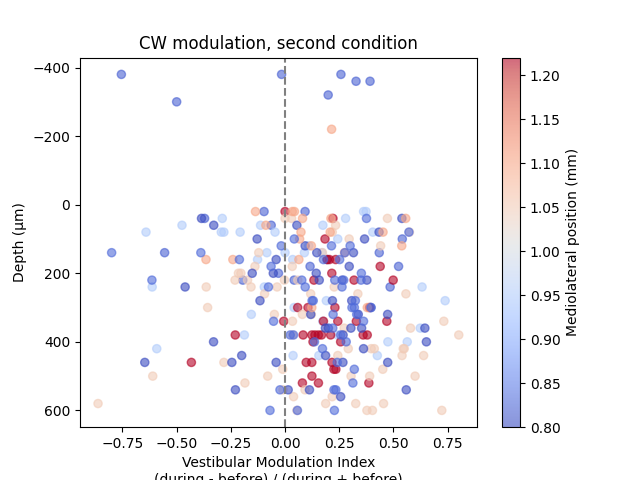

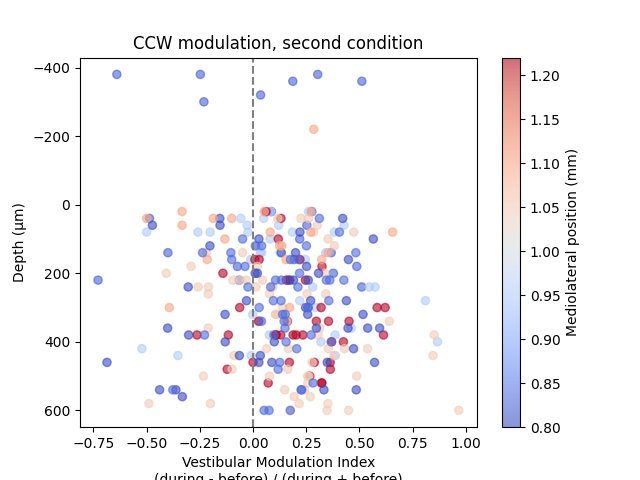

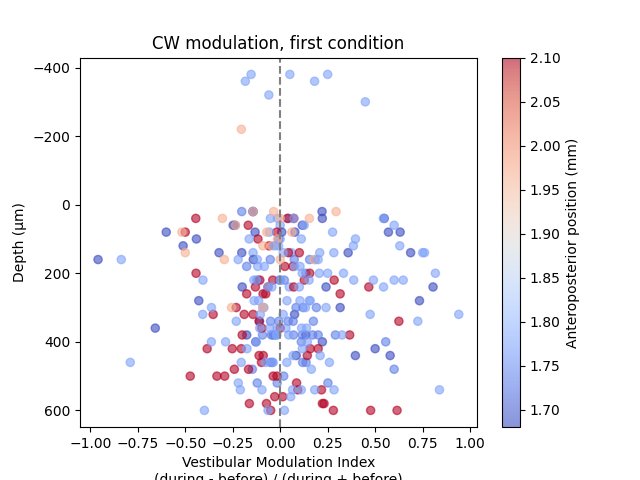

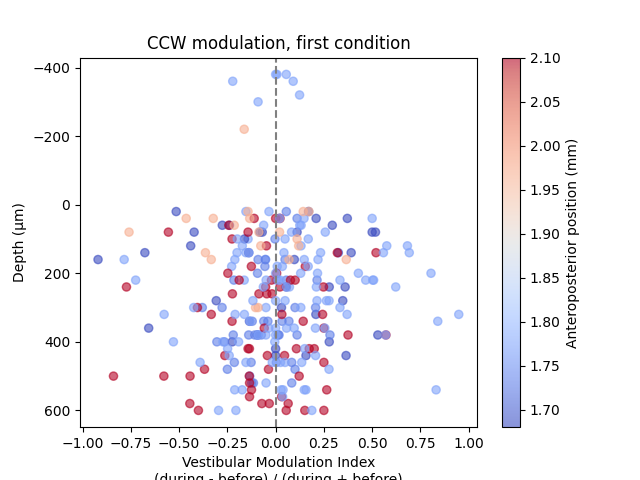

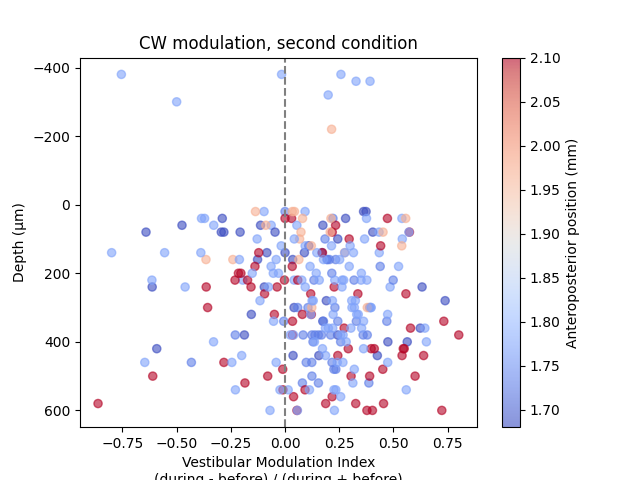

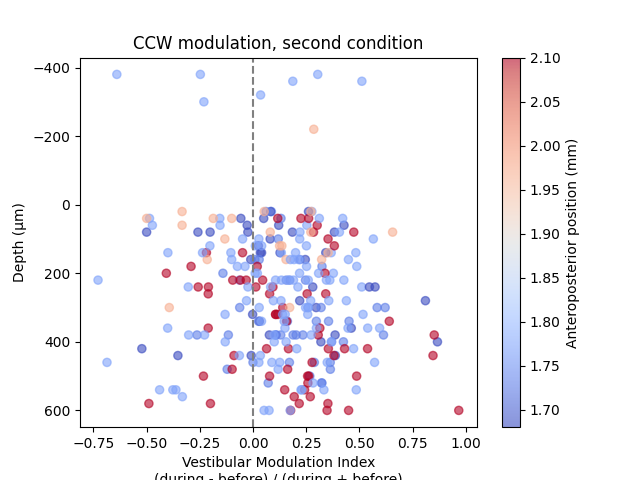

In [144]:
vMIplot = []
posplot = []
AllDepthplot = []

for pos_title, posOrientation in zip(['Mediolateral', 'Anteroposterior'], ['ML_pos', 'AP_pos']):
        for condition in ['first', 'second']:
            for direction in ['CW','CCW']:
                for animal in AllData:
                    vMIplot.extend(AllData[animal]['Statistics_data']['vMI'][condition][direction])
                    posplot.extend(AllData[animal]['informative_data'][posOrientation]*np.ones(len(AllData[animal]['Statistics_data']['vMI'][condition][direction])))
                    AllDepthplot.extend(AllData[animal]['MUA_data']['AllDepth'])
                
                plt.gca().invert_yaxis()
                plt.scatter(vMIplot, AllDepthplot, c=posplot, cmap='coolwarm', s=35, alpha=0.6)
                plt.colorbar(label=f"{pos_title} position (mm)")
                plt.axvline(0, color='gray', linestyle='--')

                plt.xlabel("Vestibular Modulation Index\n(during - before) / (during + before)")
                plt.ylabel("Depth (µm)")
                plt.title(f"{direction} modulation, {condition} condition")

                plt.show()
                vMIplot = []
                posplot = []
                AllDepthplot = []

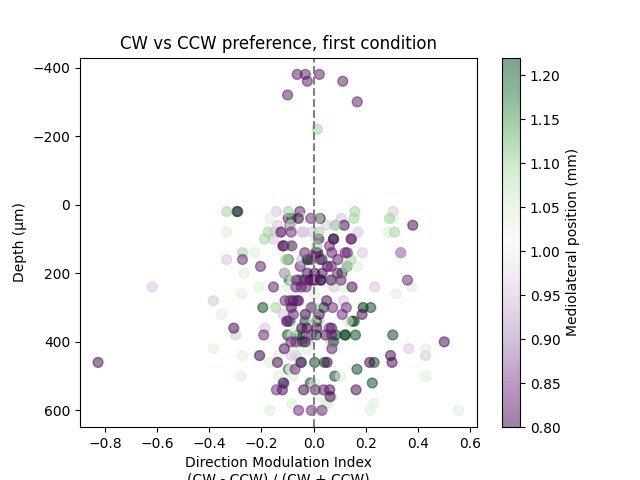

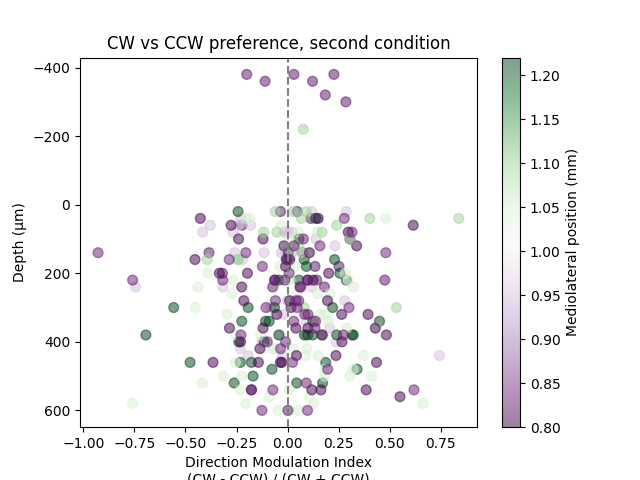

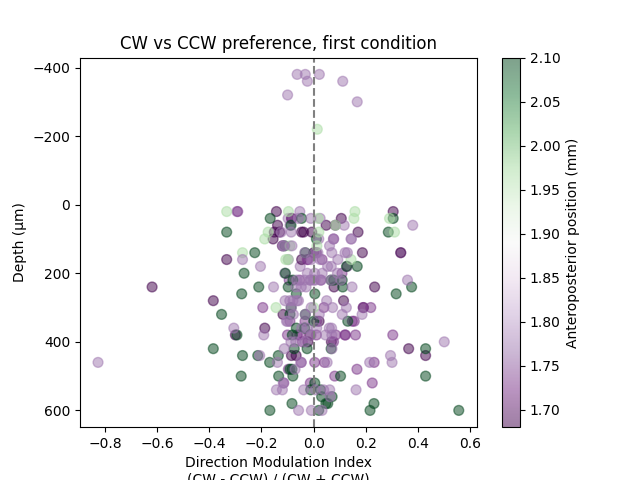

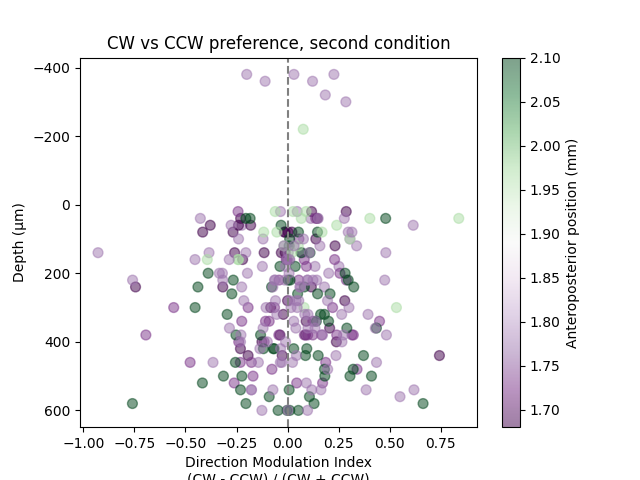

In [188]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm


dirMIplot = []
posplot = []
AllDepthplot = []
mycm = ListedColormap(['blue', 'lawngreen', 'green', 'orange', 'purple', 'red', 'orchid', 'cyan', 'magenta'])

for pos_title, posOrientation in zip(['Mediolateral', 'Anteroposterior'], ['ML_pos', 'AP_pos']):
        for condition in ['first', 'second']:
            for animal in AllData:
                dirMIplot.extend(AllData[animal]['Statistics_data']['dirMI'][condition])
                posplot.extend(AllData[animal]['informative_data'][posOrientation]*np.ones(len(AllData[animal]['Statistics_data']['dirMI'][condition])))
                AllDepthplot.extend(AllData[animal]['MUA_data']['AllDepth'])
            
            plt.gca().invert_yaxis()
            plt.scatter(dirMIplot, AllDepthplot, c=posplot, cmap='PRGn', s=50, alpha=0.5)
            plt.colorbar(label=f"{pos_title} position (mm)")
            plt.axvline(0, color='gray', linestyle='--')

            plt.xlabel("Direction Modulation Index\n(CW - CCW) / (CW + CCW)")
            plt.ylabel("Depth (µm)")
            plt.title(f"CW vs CCW preference, {condition} condition")

            plt.show()
            dirMIplot = []
            posplot = []
            AllDepthplot = []
